# P3

In [1]:
import os 
os.chdir("..")

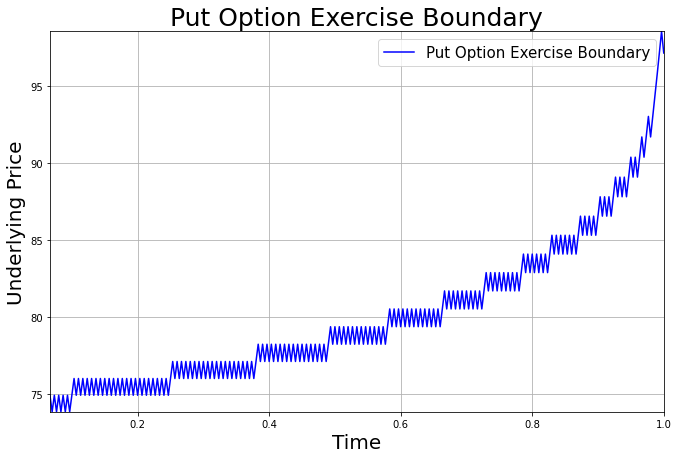

European Price = 7.459
American Price = 7.971


In [2]:
from dataclasses import dataclass
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import FinitePolicy
from rl.distribution import Constant, Categorical
from rl.finite_horizon import optimal_vf_and_policy


@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int

    def european_price(self, is_call: bool, strike: float) -> float:
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def dt(self) -> float:
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FinitePolicy[int, bool]]]:
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        return optimal_vf_and_policy(
            steps=[
                {j: None if j == -1 else {
                    True: Constant(
                        (
                            -1,
                            self.payoff(i * dt, self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (j + 1, 0.): up_prob,
                            (j, 0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FinitePolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].act(j).value and
                         self.payoff(i * dt, self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, opt_ex_bin_tree.state_price(i, boundary_pt))
                )
        return ex_boundary


if __name__ == '__main__':
    from rl.gen_utils.plot_funcs import plot_list_of_curves
    spot_price_val: float = 100.0
    strike: float = 100.0
    is_call: bool = False
    expiry_val: float = 1.0
    rate_val: float = 0.05
    vol_val: float = 0.25
    num_steps_val: int = 300

    if is_call:
        opt_payoff = lambda _, x: max(x - strike, 0)
    else:
        opt_payoff = lambda _, x: max(strike - x, 0)

    opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
        spot_price=spot_price_val,
        payoff=opt_payoff,
        expiry=expiry_val,
        rate=rate_val,
        vol=vol_val,
        num_steps=num_steps_val
    )

    vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())
    ex_boundary: Sequence[Tuple[float, float]] = \
        opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)
    time_pts, ex_bound_pts = zip(*ex_boundary)
    label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
    plot_list_of_curves(
        list_of_x_vals=[time_pts],
        list_of_y_vals=[ex_bound_pts],
        list_of_colors=["b"],
        list_of_curve_labels=[label],
        x_label="Time",
        y_label="Underlying Price",
        title=label
    )

    european: float = opt_ex_bin_tree.european_price(is_call, strike)
    print(f"European Price = {european:.3f}")

    am_price: float = vf_seq[0][0]
    print(f"American Price = {am_price:.3f}")

In [3]:
'''Approximate dynamic programming algorithms are variations on
dynamic programming algorithms that can work with function
approximations rather than exact representations of the process's
state space.
'''

from typing import Iterator, Mapping, Tuple, TypeVar, Sequence, List
from operator import itemgetter
import numpy as np

from rl.distribution import Distribution, Constant
from rl.function_approx import FunctionApprox
from rl.iterate import iterate
from rl.markov_process import (FiniteMarkovRewardProcess, MarkovRewardProcess,
                               RewardTransition)
from rl.markov_decision_process import (FiniteMarkovDecisionProcess, Policy,
                                        MarkovDecisionProcess,
                                        StateActionMapping)

S = TypeVar('S')
A = TypeVar('A')

# A representation of a value function for a finite MDP with states of
# type S
V = Mapping[S, float]


def evaluate_finite_mrp(
        mrp: FiniteMarkovRewardProcess[S],
        γ: float,
        approx_0: FunctionApprox[S]
) -> Iterator[FunctionApprox[S]]:

    '''Iteratively calculate the value function for the give finite Markov
    Reward Process, using the given FunctionApprox to approximate the
    value function at each step.
    '''
    def update(v: FunctionApprox[S]) -> FunctionApprox[S]:
        vs: np.ndarray = v.evaluate(mrp.non_terminal_states)
        updated: np.ndarray = mrp.reward_function_vec + γ * \
            mrp.get_transition_matrix().dot(vs)
        return v.update(zip(mrp.states(), updated))

    return iterate(update, approx_0)


def evaluate_mrp(
    mrp: MarkovRewardProcess[S],
    γ: float,
    approx_0: FunctionApprox[S],
    non_terminal_states_distribution: Distribution[S],
    num_state_samples: int
) -> Iterator[FunctionApprox[S]]:

    '''Iteratively calculate the value function for the given Markov Reward
    Process, using the given FunctionApprox to approximate the value function
    at each step for a random sample of the process' non-terminal states.
    '''
    def update(v: FunctionApprox[S]) -> FunctionApprox[S]:
        nt_states: Sequence[S] = non_terminal_states_distribution.sample_n(
            num_state_samples
        )

        def return_(s_r: Tuple[S, float]) -> float:
            s1, r = s_r
            return r + γ * v.evaluate([s1]).item()

        return v.update(
            [(s, mrp.transition_reward(s).expectation(return_))
             for s in nt_states]
        )

    return iterate(update, approx_0)


def value_iteration_finite(
    mdp: FiniteMarkovDecisionProcess[S, A],
    γ: float,
    approx_0: FunctionApprox[S]
) -> Iterator[FunctionApprox[S]]:
    '''Iteratively calculate the Optimal Value function for the given finite
    Markov Decision Process, using the given FunctionApprox to approximate the
    Optimal Value function at each step
    '''
    def update(v: FunctionApprox[S]) -> FunctionApprox[S]:

        def return_(s_r: Tuple[S, float]) -> float:
            s1, r = s_r
            return r + γ * v.evaluate([s1]).item()

        return v.update(
            [(
                s,
                max(mdp.mapping[s][a].expectation(return_)
                    for a in mdp.actions(s))
            ) for s in mdp.non_terminal_states]
        )

    return iterate(update, approx_0)


def value_iteration(
    mdp: MarkovDecisionProcess[S, A],
    γ: float,
    approx_0: FunctionApprox[S],
    non_terminal_states_distribution: Distribution[S],
    num_state_samples: int
) -> Iterator[FunctionApprox[S]]:
    '''Iteratively calculate the Optimal Value function for the given
    Markov Decision Process, using the given FunctionApprox to approximate the
    Optimal Value function at each step for a random sample of the process'
    non-terminal states.
    '''
    def update(v: FunctionApprox[S]) -> FunctionApprox[S]:
        nt_states: Sequence[S] = non_terminal_states_distribution.sample_n(
            num_state_samples
        )

        def return_(s_r: Tuple[S, float]) -> float:
            s1, r = s_r
            return r + γ * v.evaluate([s1]).item()

        return v.update(
            [(s, max(mdp.step(s, a).expectation(return_)
                     for a in mdp.actions(s)))
             for s in nt_states]
        )

    return iterate(update, approx_0)


def backward_evaluate_finite(
    step_f0_pairs: Sequence[Tuple[RewardTransition[S], FunctionApprox[S]]],
    γ: float
) -> Iterator[FunctionApprox[S]]:
    '''Evaluate the given finite Markov Reward Process using backwards
    induction, given that the process stops after limit time steps.
    '''

    v: List[FunctionApprox[S]] = []
    num_steps: int = len(step_f0_pairs)

    for i, (step, approx0) in enumerate(reversed(step_f0_pairs)):

        def return_(s_r: Tuple[S, float], i=i) -> float:
            s1, r = s_r
            return r + γ * (v[i-1].evaluate([s1]).item() if i > 0 and
                            step_f0_pairs[num_steps - i][0][s1] is not None
                            else 0.)

        v.append(
            approx0.solve([(s, res.expectation(return_))
                           for s, res in step.items() if res is not None])
        )

    return reversed(v)


MRP_FuncApprox_Distribution = \
    Tuple[MarkovRewardProcess[S], FunctionApprox[S], Distribution[S]]


def backward_evaluate(
    mrp_f0_mu_triples: Sequence[MRP_FuncApprox_Distribution[S]],
    γ: float,
    num_state_samples: int,
    error_tolerance: float
) -> Iterator[FunctionApprox[S]]:
    '''Evaluate the given finite Markov Reward Process using backwards
    induction, given that the process stops after limit time steps, using
    the given FunctionApprox for each time step for a random sample of the
    time step's states.
    '''
    v: List[FunctionApprox[S]] = []

    num_steps: int = len(mrp_f0_mu_triples)

    for i, (mrp, approx0, mu) in enumerate(reversed(mrp_f0_mu_triples)):

        def return_(s_r: Tuple[S, float], i=i) -> float:
            s1, r = s_r
            return r + γ * (v[i-1].evaluate([s1]).item() if i > 0 and not
                            mrp_f0_mu_triples[num_steps - i][0].is_terminal(s1)
                            else 0.)

        v.append(
            approx0.solve(
                [(s, mrp.transition_reward(s).expectation(return_))
                 for s in mu.sample_n(num_state_samples)
                 if not mrp.is_terminal(s)],
                error_tolerance
            )
        )

    return reversed(v)


def back_opt_vf_and_policy_finite(
    step_f0s: Sequence[Tuple[StateActionMapping[S, A], FunctionApprox[S]]],
    γ: float,
) -> Iterator[Tuple[FunctionApprox[S], Policy[S, A]]]:
    '''Use backwards induction to find the optimal value function and optimal
    policy at each time step
    '''
    vp: List[Tuple[FunctionApprox[S], Policy[S, A]]] = []

    num_steps: int = len(step_f0s)

    for i, (step, approx0) in enumerate(reversed(step_f0s)):

        def return_(s_r: Tuple[S, float], i=i) -> float:
            s1, r = s_r
            return r + γ * (vp[i-1][0].evaluate([s1]).item() if i > 0 and
                            step_f0s[num_steps - i][0][s1] is not None else 0.)

        this_v = approx0.solve(
            [(s, max(res.expectation(return_)
                     for a, res in actions_map.items()))
             for s, actions_map in step.items() if actions_map is not None]
        )

        class ThisPolicy(Policy[S, A]):
            def act(self, state: S) -> Constant[A]:
                return Constant(max(
                    ((res.expectation(return_), a)
                     for a, res in step[state].items()),
                    key=itemgetter(0)
                )[1])

        vp.append((this_v, ThisPolicy()))

    return reversed(vp)


MDP_FuncApproxV_Distribution = Tuple[
    MarkovDecisionProcess[S, A],
    FunctionApprox[S],
    Distribution[S]
]


def back_opt_vf_and_policy(
    mdp_f0_mu_triples: Sequence[MDP_FuncApproxV_Distribution[S, A]],
    γ: float,
    num_state_samples: int,
    error_tolerance: float
) -> Iterator[Tuple[FunctionApprox[S], Policy[S, A]]]:
    '''Use backwards induction to find the optimal value function and optimal
    policy at each time step, using the given FunctionApprox for each time step
    for a random sample of the time step's states.
    '''
    vp: List[Tuple[FunctionApprox[S], Policy[S, A]]] = []

    num_steps: int = len(mdp_f0_mu_triples)

    for i, (mdp, approx0, mu) in enumerate(reversed(mdp_f0_mu_triples)):

        def return_(s_r: Tuple[S, float], i=i) -> float:
            s1, r = s_r
            return r + γ * (vp[i-1][0].evaluate([s1]).item() if i > 0 and not
                            mdp_f0_mu_triples[num_steps - i][0].is_terminal(s1)
                            else 0.)

        this_v = approx0.solve(
            [(s, max(mdp.step(s, a).expectation(return_)
                     for a in mdp.actions(s)))
             for s in mu.sample_n(num_state_samples)
             if not mdp.is_terminal(s)],
            error_tolerance
        )

        class ThisPolicy(Policy[S, A]):
            def act(self, state: S) -> Constant[A]:
                return Constant(max(
                    ((mdp.step(state, a).expectation(return_), a)
                     for a in mdp.actions(state)),
                    key=itemgetter(0)
                )[1])

        vp.append((this_v, ThisPolicy()))

    return reversed(vp)


MDP_FuncApproxQ_Distribution = Tuple[
    MarkovDecisionProcess[S, A],
    FunctionApprox[Tuple[S, A]],
    Distribution[S]
]


def back_opt_qvf(
    mdp_f0_mu_triples: Sequence[MDP_FuncApproxQ_Distribution[S, A]],
    γ: float,
    num_state_samples: int,
    error_tolerance: float
) -> Iterator[FunctionApprox[Tuple[S, A]]]:
    '''Use backwards induction to find the optimal q-value function  policy at
    each time step, using the given FunctionApprox (for Q-Value) for each time
    step for a random sample of the time step's states.
    '''
    horizon: int = len(mdp_f0_mu_triples)
    qvf: List[FunctionApprox[Tuple[S, A]]] = []

    num_steps: int = len(mdp_f0_mu_triples)

    for i, (mdp, approx0, mu) in enumerate(reversed(mdp_f0_mu_triples)):

        def return_(s_r: Tuple[S, float], i=i) -> float:
            s1, r = s_r
            return r + γ * (
                max(qvf[i-1].evaluate([(s1, a)]).item()
                    for a in mdp_f0_mu_triples[horizon - i][0].actions(s1))
                if i > 0 and
                not mdp_f0_mu_triples[num_steps - i][0].is_terminal(s1)
                else 0.
            )

        this_qvf = approx0.solve(
            [((s, a), mdp.step(s, a).expectation(return_))
             for s in mu.sample_n(num_state_samples)
             if not mdp.is_terminal(s) for a in mdp.actions(s)],
            error_tolerance
        )

        qvf.append(this_qvf)

    return reversed(qvf)

# Solve with Approximation_DP

In [ ]:
value_iteration_finite(get_mdp(opt_ex_bin_tree))